In [1]:
# interpolate [co2] from 47 model levels to 20 OCO2 levels

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re

In [4]:
# month of the simulation
month  = 1     # 1,2,3
case_name = 'CO2-2018-01'

In [5]:
if(month >= 10):
    model_file = '2d_ts_satellite.2018' + str(month) + '.nc'
    satellite_file = '2d_OCO2_extract_2018' + str(month) + '.nc'
else:
    model_file = '2d_ts_satellite.20180' + str(month) + '.nc'
    satellite_file = '2d_OCO2_extract_20180' + str(month) + '.nc'

In [6]:
# Name and path of inputs and outputs
input_directory = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/' + case_name + '/nd51/'
input_file = input_directory + model_file
# corresponding satellite data
satellite_directory = '/geos/u73/msadiq/satellite/oco-2/'

output_file = input_directory + 'interpolated_' + model_file
output_directory = input_directory

In [7]:
# model input
ds_model          = xr.open_dataset(input_file)

levels_model      = ds_model['levels']
surf_press_mod    = ds_model['PEDGE_S_PSURF']
profile_press_mod = surf_press_mod * levels_model # pressure at different levels
record            = ds_model['record'].values

In [8]:
# satellite input
ds_satellite = xr.open_dataset(satellite_directory + satellite_file)
levels_sat = ds_satellite['levels']
surf_press_sat = ds_satellite['psurf']       # not really needed
profile_press_sat = ds_satellite['pressure'] # pressure profile of different levels
print(profile_press_sat[9442].values)
# multi_pressure = surf_pressure * levels_sat
# multi_pressure[47007,:].values            # same as pressure profile

[9.8219998e-02 5.1694736e+01 1.0338947e+02 1.5508421e+02 2.0677895e+02
 2.5847369e+02 3.1016843e+02 3.6186316e+02 4.1355789e+02 4.6525266e+02
 5.1694739e+02 5.6864209e+02 6.2033685e+02 6.7203162e+02 7.2372632e+02
 7.7542108e+02 8.2711578e+02 8.7881055e+02 9.3050531e+02 9.8220001e+02]


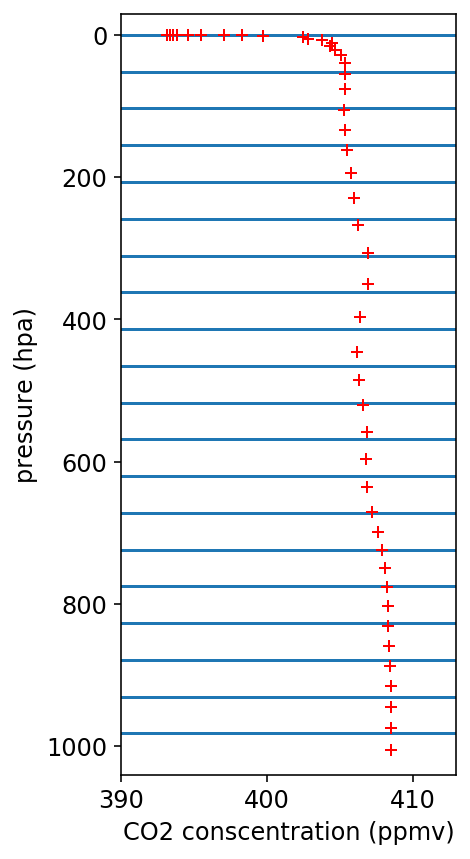

In [9]:
# pick one location where we have data from OCO2 
# and show difference in levels
irecord = 9442
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][47007,:] # 47 levels

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+') # co2 unit is still ppbv here
ax.set_ylim(1040,-30)  # reverse y axis
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hpa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

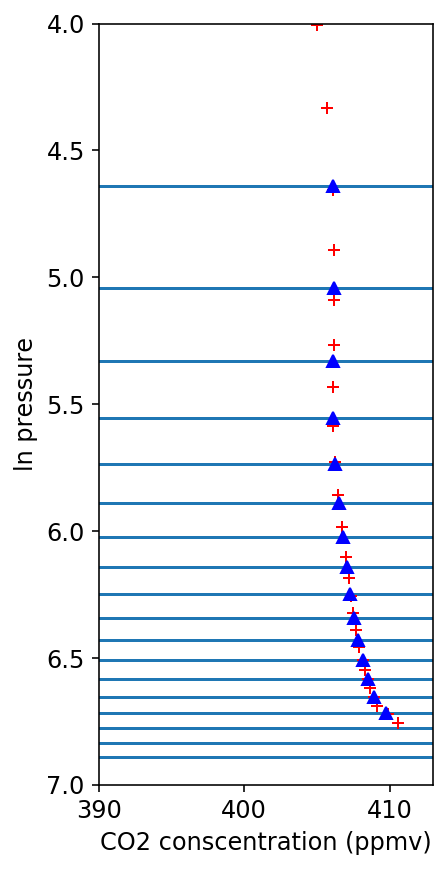

In [10]:
# pick one location where we have data from OCO2
# show in ln pressure coordinate
# linear interpolation using ln(pressure)
# show results of interpolation
y_press_mod = np.log(profile_press_mod[irecord,:].values)
y_press_sat = np.log(profile_press_sat[irecord].values)
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

interpolated_co2 = np.interp(x = y_press_sat, xp = np.flip(y_press_mod), fp = np.flip(x_co2)) # linear inte

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(7,4)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('ln pressure')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()

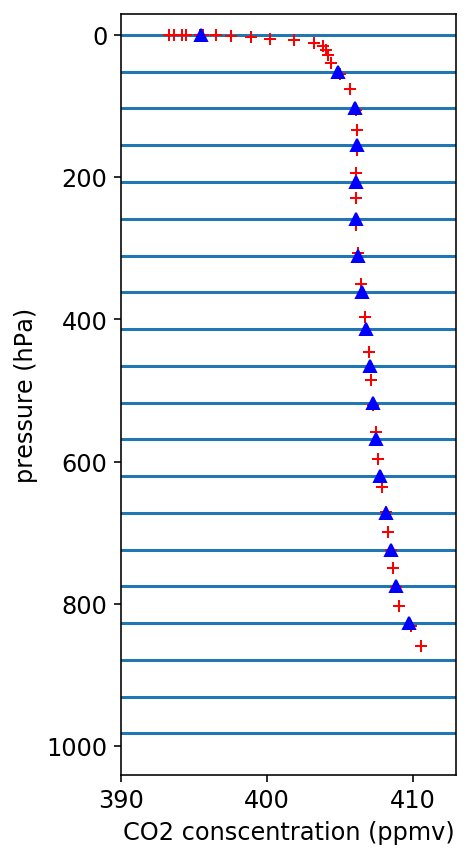

In [11]:
y_press_mod = profile_press_mod[irecord,:].values
y_press_sat = profile_press_sat[irecord].values
x_co2       = ds_model['SpeciesConc_CO2'][irecord,:]

fig, ax = plt.subplots(figsize=[3,7])

ax.plot(x_co2*1e-3, y_press_mod, 'r+')
ax.plot(interpolated_co2*1e-3, y_press_sat, 'b^')
ax.set_ylim(1040,-30)
ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure (hPa)')
ax.eventplot(y_press_sat, lineoffsets=400, # add horizonal lines of satellite pressure levels
                    linelengths=100, orientation = 'vertical')

plt.show()
fig.savefig(output_directory + 'interpolation.png', bbox_inches='tight')

In [12]:
# new dataset to store interpolated co2 from model
interpolated = ds_satellite['pressure'].to_dataset()
interpolated

<xarray.Dataset>
Dimensions:   (levels: 20, record: 406224)
Coordinates:
  * record    (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels    (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0
Data variables:
    pressure  (record, levels) float32 ...

In [13]:
varnames = list(ds_model.keys())  # Get a list of variable names. The expression is a bit cumbersome. Just copy and paste it for now.
nvar = len(varnames)  # how many elements in the list?
needed_vars = np.append(varnames[0], varnames[7:29])
needed_vars

array(['SpeciesConc_CO2', 'SpeciesConc_CO2Tag1', 'SpeciesConc_CO2Tag2',
       'SpeciesConc_CO2Tag3', 'SpeciesConc_CO2Tag4',
       'SpeciesConc_CO2Tag5', 'SpeciesConc_CO2Tag6',
       'SpeciesConc_CO2Tag7', 'SpeciesConc_CO2Tag8',
       'SpeciesConc_CO2Tag9', 'SpeciesConc_CO2Tag10',
       'SpeciesConc_CO2Tag11', 'SpeciesConc_CO2Tag12',
       'SpeciesConc_CO2Tag13', 'SpeciesConc_CO2Tag14',
       'SpeciesConc_CO2Tag15', 'SpeciesConc_CO2Tag16',
       'SpeciesConc_CO2Tag17', 'SpeciesConc_CO2Tag18',
       'SpeciesConc_CO2Tag19', 'SpeciesConc_CO2Tag20',
       'SpeciesConc_CO2Tag21', 'SpeciesConc_CO2Tag22'], dtype='<U20')

In [14]:
# temporary 2d dataarray to save interpolated data
tmp = xr.DataArray(data = 0,
                   dims=('record', 'levels'),
                   coords=[record, ds_satellite.coords['levels']])
tmp = tmp.astype(dtype = 'float32')
tmp

<xarray.DataArray (record: 406224, levels: 20)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels   (levels) float32 1e-04 0.05263158 0.10526316 ... 0.94736844 1.0

In [15]:
for ivar in needed_vars:
    interpolated[ivar] = tmp.copy()
interpolated

<xarray.Dataset>
Dimensions:               (levels: 20, record: 406224)
Coordinates:
  * record                (record) int64 0 1 2 3 ... 406220 406221 406222 406223
  * levels                (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    pressure              (record, levels) float32 ...
    SpeciesConc_CO2       (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag1   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag2   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag3   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag4   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag5   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag6   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag7   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag8   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag9   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag10  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag11  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag12  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag13  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag14  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag15  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag16  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag17  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag18  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag19  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag20  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag21  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag22  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [16]:
# interpolation
for irecord in record:
    if profile_press_sat[irecord][19] != 0.:   # if measurement is non-zero, i.e. exists
        for ivar in needed_vars:
            before         = ds_model[ivar] # get co2 before interpolation
            x_co2          = before[irecord,:].values # a co2 profile
            pres_before    = np.log(profile_press_mod[irecord].values) # log space
            pres_after     = np.log(profile_press_sat[irecord])
            # linear interpolation            
            interpolated[ivar][irecord,:] = np.interp(x  = pres_after, 
                                                      xp = np.flip(pres_before), # increasing order
                                                      fp = np.flip(x_co2)) 
        print(irecord)

479
869
1297
1361
1687
1688
1811
2202
2346
2366
2490
2519
2549
2633
2634
2693
2732
2777
2836
2856
2876
2886
2940
2941
3000
3020
3029
3084
3144
3163
3164
3173
3188
3228
3287
3288
3307
3317
3332
3411
3451
3461
3476
3595
3604
3620
3640
3669
3699
3738
3739
3748
3764
3783
3813
3843
3873
3882
3892
3927
3957
3967
3987
4006
4017
4026
4036
4091
4101
4110
4111
4150
4161
4170
4180
4215
4244
4245
4254
4274
4294
4305
4314
4359
4378
4388
4398
4418
4438
4449
4457
4502
4522
4532
4542
4562
4581
4582
4646
4676
4686
4725
4755
4790
4820
4830
4849
4869
4889
4899
4934
4963
4973
4993
5013
5033
5058
5078
5107
5117
5157
5177
5202
5221
5222
5251
5261
5320
5330
5345
5346
5365
5385
5405
5444
5445
5474
5489
5509
5529
5539
5549
5588
5608
5618
5633
5653
5693
5703
5761
5777
5797
5876
5905
5921
5941
5960
5970
6020
6049
6065
6084
6104
6114
6144
6193
6208
6209
6228
6248
6258
6279
6288
6337
6352
6372
6383
6392
6402
6422
6431
6481
6496
6516
6527
6536
6546
6575
6624
6625
6660
6670
6689
6710
6719
6768
6784
6854
6863
6912
69

48185
48196
48309
48328
48329
48388
48403
48413
48424
48472
48557
48596
48700
48818
48844
48934
48962
49078
49222
49366
53286
53287
53587
53588
53725
53874
54066
54190
54210
54250
54334
54353
54373
54457
54458
54477
54478
54497
54586
54601
54641
54700
54784
54785
54844
54908
54987
55032
55111
55131
55176
55196
55275
55319
55339
55359
55399
55448
55453
55454
55463
55483
55523
55542
55591
55666
55686
55735
55771
55810
55830
55885
55934
55954
55974
56023
56028
56029
56058
56078
56117
56167
56172
56182
56202
56222
56261
56281
56292
56326
56346
56365
56366
56405
56425
56435
56436
56454
56470
56489
56490
56509
56549
56569
56579
56588
56614
56633
56693
56712
56723
56732
56777
56788
56817
56836
56837
56856
56867
56876
56886
56891
56901
56921
56941
56960
56961
56980
57000
57011
57020
57029
57030
57035
57045
57065
57084
57085
57104
57124
57144
57154
57155
57164
57173
57179
57189
57208
57209
57228
57248
57268
57288
57307
57317
57323
57333
57352
57363
57372
57392
57412
57431
57451
57461
57467
5747

98962
98973
99002
99013
99022
99041
99042
99061
99086
99106
99136
99146
99156
99157
99165
99166
99185
99205
99230
99250
99280
99300
99309
99329
99349
99374
99394
99433
99444
99453
99464
99473
99493
99518
99557
99567
99588
99597
99617
99636
99646
99662
99681
99701
99711
99732
99751
99752
99780
99790
99805
99825
99845
99855
99895
99924
99934
99949
99969
99989
99998
99999
100008
100019
100039
100048
100068
100078
100093
100113
100132
100133
100142
100163
100172
100183
100192
100211
100212
100221
100237
100256
100257
100276
100286
100296
100307
100316
100327
100355
100365
100400
100430
100451
100459
100471
100499
100544
100583
100584
100595
100603
100614
100643
100727
100747
100787
100882
100891
101034
101046
101198
101322
101341
101342
101485
101530
101629
106430
106668
106851
106955
106975
106994
107039
107099
107138
107183
107282
107327
107346
107366
107386
107425
107435
107451
107470
107490
107569
107579
107614
107634
107713
107723
107738
107758
107817
107856
107857
107866
107882
10790

140498
140507
140518
140611
140622
140642
140650
140651
140662
140766
140806
141093
141237
146225
146244
146245
146328
146348
146388
146427
146472
146492
146571
146600
146616
146636
146675
146715
146744
146750
146759
146760
146819
146858
146859
146888
146903
146963
147002
147031
147032
147037
147126
147146
147166
147181
147191
147289
147290
147309
147319
147324
147325
147334
147335
147354
147453
147463
147468
147478
147498
147518
147622
147642
147661
147662
147681
147701
147785
147786
147805
147825
147845
147865
147884
147894
147909
147910
147929
147949
147969
147989
148009
148028
148038
148053
148093
148113
148132
148152
148172
148182
148197
148217
148237
148256
148257
148276
148296
148341
148361
148380
148381
148400
148420
148440
148451
148460
148485
148504
148505
148544
148564
148584
148594
148603
148688
148708
148727
148728
148738
148747
148792
148832
148842
148851
148871
148882
148891
148936
148956
148986
148995
149015
149026
149035
149060
149080
149090
149130
149139
149170
149179

187660
187670
187689
187709
187729
187749
187759
187769
187803
187804
187813
187814
187824
187833
187853
187873
187903
187937
187947
187957
187968
187977
187997
188016
188017
188036
188047
188056
188066
188081
188091
188101
188112
188141
188160
188180
188191
188200
188210
188225
188235
188284
188324
188335
188344
188369
188379
188389
188428
188448
188478
188479
188513
188523
188532
188533
188572
188622
188656
188657
188666
188676
188716
188766
188775
188800
188810
188820
188919
188944
188954
188964
189014
189023
189063
189088
189098
189108
189118
189127
189128
189216
189232
189242
189252
189271
189291
189360
189376
189385
189386
189395
189396
189415
189435
189504
189519
189520
189529
189539
189579
189663
189673
189683
189694
189742
189807
189817
189827
189847
189886
189926
189951
189971
189990
189991
190070
190095
190105
190115
190125
190134
190165
190174
190213
190239
190248
190249
190382
190392
190413
190422
190452
190453
190501
190526
190536
190596
190616
190645
190670
190690
190700

228992
229022
229031
229032
229051
229110
229111
229126
229136
229146
229166
229175
229195
229245
229254
229270
229280
229309
229339
229388
229398
229414
229423
229424
229483
229532
229542
229557
229597
229617
229618
229627
229731
229741
229770
229771
229820
229829
229830
229855
229875
229885
229914
229964
229973
229999
230049
230058
230107
230108
230117
230143
230162
230172
230182
230193
230202
230251
230261
230337
230346
230365
230395
230405
230450
230481
230489
230490
230509
230539
230548
230549
230574
230594
230624
230633
230653
230683
230692
230708
230718
230737
230738
230768
230777
230797
230817
230827
230836
230851
230852
230861
230862
230881
230891
230912
230921
230932
230941
230970
230995
231005
231025
231035
231045
231056
231064
231065
231075
231076
231084
231104
231139
231149
231160
231169
231189
231199
231200
231208
231219
231228
231239
231293
231304
231312
231313
231343
231352
231363
231383
231392
231401
231436
231437
231456
231487
231496
231507
231545
231580
231591
231600

270373
270374
270393
270413
270423
270433
270448
270458
270478
270488
270497
270508
270509
270517
270528
270537
270567
270576
270592
270602
270641
270652
270661
270672
270681
270700
270701
270745
270746
270756
270775
270785
270796
270805
270844
270889
270900
270909
270919
270929
270940
271044
271062
271063
271073
271084
271177
271196
271206
271227
271340
271411
271484
271543
271554
271555
271647
271687
271698
271802
271842
275663
276648
276766
276775
276776
276801
276910
276984
277088
277300
277320
277414
277424
277444
277464
277493
277528
277568
277588
277637
277672
277771
277780
277781
277816
277875
277924
277939
277940
277959
277999
278039
278068
278083
278103
278133
278143
278212
278227
278247
278306
278346
278371
278390
278391
278430
278450
278489
278515
278534
278633
278643
278668
278678
278708
278777
278787
278802
278812
278822
278851
278852
278861
278901
278946
278966
278976
278986
278995
279005
279074
279090
279099
279100
279110
279120
279139
279149
279208
279218
279233
279243

310288
310353
310361
310362
310381
310392
310393
310412
310432
310497
310505
310525
310536
310556
310576
310640
310641
310680
310689
310784
310813
310824
310843
310967
310968
311072
311111
311151
315976
316006
316016
316075
316084
316119
316149
316159
316218
316228
316238
316253
316362
316371
316406
316446
316505
316506
316530
316540
316550
316649
316694
316733
316802
316812
316867
316877
316946
317040
317060
317080
317099
317124
317125
317144
317223
317224
317233
317243
317258
317268
317288
317377
317387
317392
317511
317615
317635
317655
317699
317759
317798
317833
317843
317903
317942
317967
317977
317987
317998
318046
318066
318105
318106
318111
318121
318131
318141
318142
318151
318170
318190
318249
318265
318285
318294
318304
318373
318393
318398
318399
318418
318438
318448
318458
318478
318497
318517
318537
318542
318552
318562
318582
318592
318602
318621
318641
318661
318681
318686
318696
318706
318717
318726
318736
318745
318746
318765
318785
318824
318830
318840
318850
318860

357405
357414
357440
357451
357460
357469
357519
357538
357539
357548
357549
357564
357583
357584
357603
357613
357623
357663
357682
357692
357702
357708
357727
357747
357757
357767
357806
357826
357836
357851
357861
357871
357891
357901
357911
357921
357930
357950
357961
357970
357980
358005
358015
358035
358044
358054
358065
358094
358114
358124
358133
358139
358149
358159
358198
358209
358238
358267
358268
358277
358283
358292
358293
358302
358303
358342
358353
358362
358381
358382
358392
358411
358421
358426
358427
358436
358446
358486
358496
358497
358506
358525
358536
358580
358590
358620
358630
358640
358649
358669
358724
358734
358764
358773
358774
358784
358793
358813
358833
358868
358878
358907
358917
358937
358957
358967
358977
358996
359012
359022
359051
359061
359081
359101
359140
359155
359156
359165
359195
359205
359225
359244
359245
359284
359299
359309
359339
359349
359359
359368
359369
359443
359453
359483
359493
359512
359532
359571
359587
359597
359636
359656
359676

In [17]:
# variables need not to be interpolated
noneed_interp = ['lat', 'lon', 'date']
for ivar in noneed_interp:
    interpolated[ivar] = ds_model[ivar].copy()

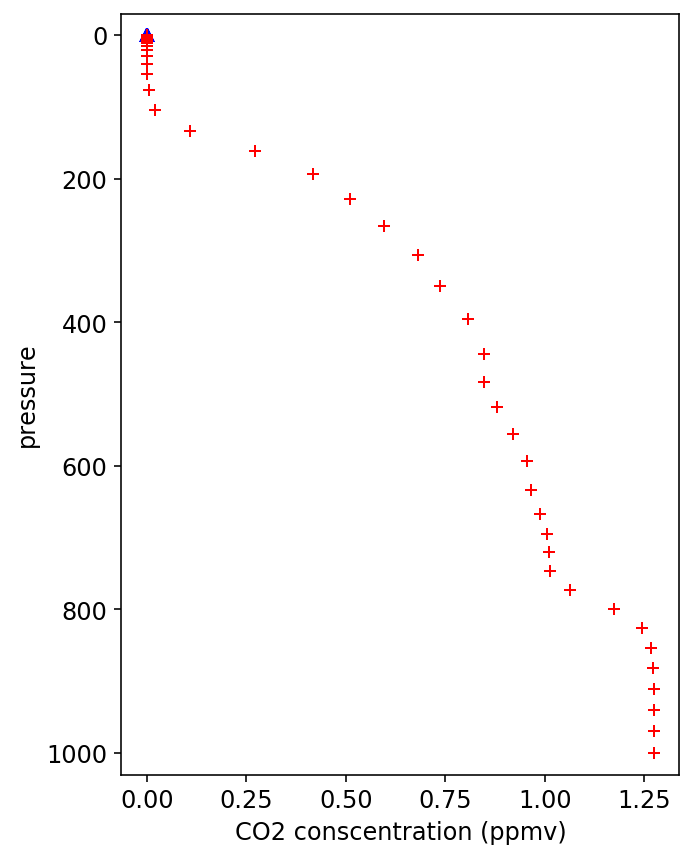

In [18]:
# after interpolation
irecord = 286636
varname = 'SpeciesConc_CO2Tag11'
x_co2_after    = interpolated[varname][irecord,:]
y_press_after  = interpolated['pressure'][irecord,:]

x_co2_before   = ds_model[varname][irecord,:]
y_press_before = profile_press_mod[irecord]

fig, ax = plt.subplots(figsize=[5,7])

ax.plot(x_co2_after*1e-3, y_press_after, 'b^')
ax.plot(x_co2_before*1e-3, y_press_before, 'r+')
ax.set_ylim(1030,-30)
#ax.set_xlim(390,413)
ax.set_xlabel('CO2 conscentration (ppmv)')
ax.set_ylabel('pressure')

plt.show()

In [19]:
interpolated.attrs['comment'] = 'interpolated from 47 level model outputs'
interpolated.to_netcdf(output_file)

In [20]:
interpolated

<xarray.Dataset>
Dimensions:               (levels: 20, record: 406224)
Coordinates:
  * record                (record) int64 0 1 2 3 ... 406220 406221 406222 406223
  * levels                (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    pressure              (record, levels) float32 ...
    SpeciesConc_CO2       (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag1   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag2   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag3   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag4   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag5   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag6   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag7   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag8   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag9   (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag10  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag11  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag12  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag13  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag14  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag15  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag16  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag17  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag18  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag19  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag20  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag21  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SpeciesConc_CO2Tag22  (record, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lat                   (record) float64 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon                   (record) float64 -180.0 -177.5 -175.0 ... 175.0 177.5
    date                  (record) datetime64[ns] 2018-01-01 ... 2018-01-31
Attributes:
    comment:  interpolated from 47 level model outputs